In [ ]:
# Feature Engineering for Customer Churn Prediction

## Objective
Transform raw customer data into meaningful, business-driven features
that capture customer behavior, risk patterns, and value indicators.

This notebook focuses on:
- Time-aware behavior proxies
- Risk flags
- Value-based features
- Model-ready feature preparation


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")


In [2]:
DATA_PATH = "../data/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(DATA_PATH)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#data cleaning
# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Handle missing values
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Drop ID column
df.drop("customerID", axis=1, inplace=True)

# Encode target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


C:\Users\alfiy\AppData\Local\Temp\ipykernel_45148\1634985979.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


In [4]:
#Time-Aware Behavior Features
# Average spend per month (behavior proxy)
df["avg_monthly_spend"] = df["TotalCharges"] / (df["tenure"] + 1)

# Early churn risk flag
df["early_churn_risk"] = (df["tenure"] < 6).astype(int)

df[["tenure", "TotalCharges", "avg_monthly_spend", "early_churn_risk"]].head()


,tenure,TotalCharges,avg_monthly_spend,early_churn_risk
0,1,29.85,14.925000,1
1,34,1889.50,53.985714,0
2,2,108.15,36.050000,1
3,45,1840.75,40.016304,0
4,2,151.65,50.550000,1


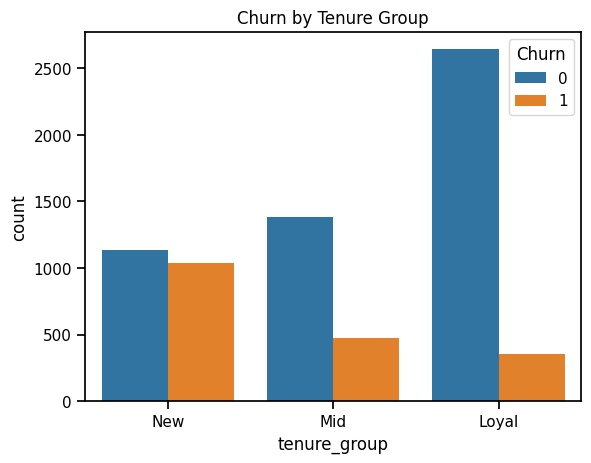

In [5]:
#Tenure Segmentation (Customer Lifecycle)
df["tenure_group"] = pd.cut(
    df["tenure"],
    bins=[0, 12, 36, 72],
    labels=["New", "Mid", "Loyal"]
)

df["tenure_group"].value_counts()
sns.countplot(x="tenure_group", hue="Churn", data=df)
plt.title("Churn by Tenure Group")
plt.show()


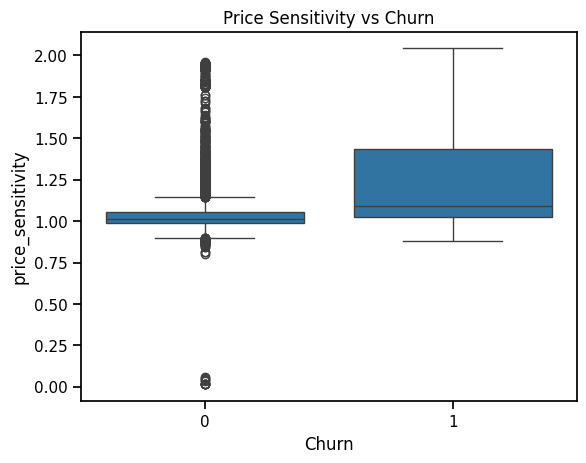

In [6]:
#Price Sensitivity Indicator
df["price_sensitivity"] = df["MonthlyCharges"] / (df["avg_monthly_spend"] + 1)
sns.boxplot(x="Churn", y="price_sensitivity", data=df)
plt.title("Price Sensitivity vs Churn")
plt.show()


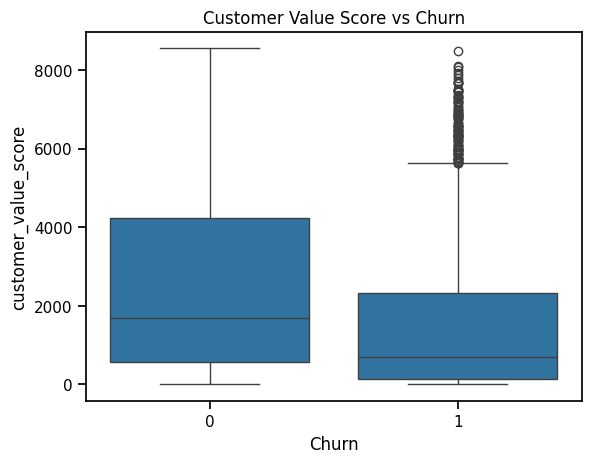

In [7]:
#Customer Value Score
df["customer_value_score"] = df["tenure"] * df["MonthlyCharges"]
sns.boxplot(x="Churn", y="customer_value_score", data=df)
plt.title("Customer Value Score vs Churn")
plt.show()


In [8]:
#Service Complexity Indicator
service_cols = [
    "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]

df["service_count"] = df[service_cols].apply(
    lambda x: (x == "Yes").sum(), axis=1
)

df["service_count"].head()


0    1
1    3
2    3
3    3
4    1
Name: service_count, dtype: int64

In [9]:
#Prepare Final Dataset for Modeling
X = df.drop("Churn", axis=1)
y = df["Churn"]

X.shape, y.shape


((7043, 25), (7043,))

In [10]:
#Save Feature-Engineered Dataset
FEATURE_DATA_PATH = "../data/churn_feature_engineered.csv"
df.to_csv(FEATURE_DATA_PATH, index=False)

FEATURE_DATA_PATH


'../data/churn_feature_engineered.csv'

In [ ]:
## Conclusion

This notebook transformed raw customer data into
behavior-driven, business-aligned features.

Key outcomes:
- Added time-aware behavior proxies
- Created actionable risk indicators
- Prepared data for cost-sensitive modeling

